In [13]:
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import torch

from torchvision.models import mobilenet_v2
from torchvision.models import resnet18
from torchvision import transforms
from torchvision import models

from matplotlib import pyplot as plt

from PIL import Image
import numpy as np
import json
import os

In [14]:
class MPIIDataset(Dataset):
    def __init__(self, data_folder, transform=None):
        self.data_folder = data_folder
        self.transform = transform
        self.data = self.load_data()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_folder, 'mpii_human_pose_v1/images', self.data[idx]['img_paths'])
        image = Image.open(img_path).convert('RGB')
        joints = torch.tensor(self.data[idx]['joint_self'], dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, joints

    def load_data(self):
        json_path = os.path.join(self.data_folder, 'mpii_annotations.json')
        with open(json_path, 'r') as f:
            data = json.load(f)
            
        for entry in data:
            img_width = entry["img_width"]
            img_height = entry["img_height"]

            for temp in entry["joint_self"]:
                temp[0] = round((temp[0] / img_width) * 224)
                temp[1] = round((temp[1] / img_height) * 224)

            entry["objpos"] = (
                round((entry["objpos"][0] / img_width) * 224),
                round((entry["objpos"][1] / img_height) * 224)
            )

            entry["img_width"] = 224
            entry["img_height"] = 224

        return data

In [15]:
# Define your own transformation if needed
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [16]:
# Provide the path to your dataset folder
data_folder = '/kaggle/input/mpii-human-pose/'

# Create dataset and data loader
mpi_dataset = MPIIDataset(data_folder, transform=transform)
mpi_dataloader = DataLoader(mpi_dataset, batch_size=32, shuffle=True, num_workers=4)

In [20]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        # Load the pre-trained weights of MobileNetV2 and freeze the weights
        self.backbone = mobilenet_v2(pretrained=True)
        for param in self.backbone.parameters():
            param.requires_grad = False

        # Initialize num_keypoints as a class attribute
        self.num_keypoints = 16

        # Modify the last layer of the backbone
        self.backbone.classifier[1] = nn.Sequential(
            nn.Conv2d(self.backbone.last_channel, self.num_keypoints * 3, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(self.num_keypoints * 3, self.num_keypoints * 3, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.backbone.features(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1, 1, 1)
        x = self.backbone.classifier.to(x.device)(x)
        x = x.view(x.size(0), self.num_keypoints, 3)
        return x

In [21]:
# Instantiate your model, loss function, and optimizer
model = MyModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
num_epochs = 2

In [22]:
print(model)

MyModel(
  (backbone): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1, 1

In [23]:
for epoch in range(num_epochs):
    model.train()

    for batch_idx, (images, joints) in enumerate(mpi_dataloader):
        images, joints = images.cuda(), joints.cuda()
        optimizer.zero_grad()
        outputs = model(images).to(device)

        loss = criterion(outputs, joints)
        loss.backward()
        optimizer.step()

        if (batch_idx + 1) % 10 == 0:
            print(f'Epoch {epoch + 1} in {num_epochs}, Batch {batch_idx + 1}/{len(mpi_dataloader)}, Loss: {loss.item()}')

print("Training finished!")

Epoch 1 in 2, Batch 10/788, Loss: 9103.09765625
Epoch 1 in 2, Batch 20/788, Loss: 9833.76171875


KeyboardInterrupt: 

In [9]:
def visualize_batch_predictions(images, keypoints, predicted_keypoints, num_images=4, target_size=(224, 224)):
    """
    Visualize a batch of input images with ground truth and predicted keypoints.

    Args:
        images (Tensor): Batch of input image tensors.
        keypoints (Tensor): Batch of ground truth keypoints.
        predicted_keypoints (Tensor): Batch of predicted keypoints.
        num_images (int): Number of images to visualize.
        target_size (tuple): Target size for visualization (height, width).
    """
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(target_size),
        transforms.ToTensor(),
    ])

    images_resized = torch.stack([transform(image) for image in images[:num_images].cpu()])
    keypoints = keypoints[:num_images].cpu().numpy()
    predicted_keypoints = predicted_keypoints[:num_images].cpu().detach().numpy()

    for i in range(num_images):
        plt.subplot(2, 2, i + 1)
        image = images_resized[i].permute(1, 2, 0).numpy()  # Convert image tensor to numpy array and change channel order
        plt.imshow(image)
        plt.scatter(keypoints[i, :, 0], keypoints[i, :, 1], s=10, c='r', marker='o', label='Ground Truth')
        plt.scatter(predicted_keypoints[i, :, 0], predicted_keypoints[i, :, 1], s=10, c='b', marker='o', label='Predicted')
        plt.title(f'Image {i + 1}')
        plt.legend()

    plt.tight_layout()
    plt.show()

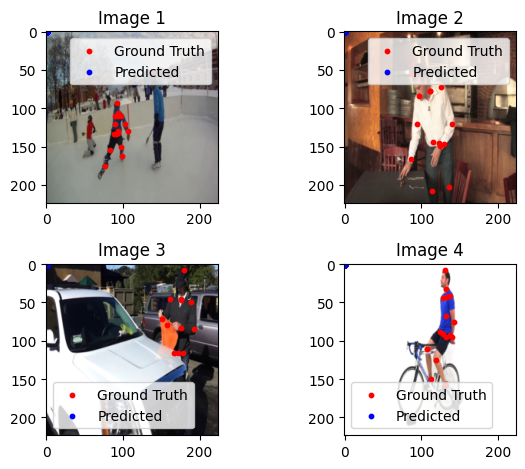

In [10]:
# Example usage:
# Assuming you have a batch of test images and their corresponding ground truth keypoints
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

mpi_dataset = MPIIDataset(data_folder, transform=transform)
mpi_dataloader = DataLoader(mpi_dataset, batch_size=64, shuffle=True, num_workers=4)

batch_images, batch_ground_truth_keypoints = next(iter(mpi_dataloader))
batch_images = batch_images.to(device)
batch_ground_truth_keypoints = batch_ground_truth_keypoints.to(device)

# Forward pass to get model predictions
model.eval()
with torch.no_grad():
    batch_predicted_keypoints = model(batch_images)

# Visualize the predictions for the first four images in the batch
visualize_batch_predictions(batch_images, batch_ground_truth_keypoints, batch_predicted_keypoints)